In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- Load data ---
binance_data = pd.read_csv("uniswap_lp_data/data_replication_lvr/binance_ETH_data.csv", parse_dates=["close_time"])
dune_data = pd.read_csv("uniswap_lp_data/data_replication_lvr/univ2_ETH_USDC_data.csv", parse_dates=["time"])

# --- Preprocess ---

# Explicitly parse the column to datetime
binance_data["close_time"] = pd.to_datetime(binance_data["close_time"], errors="coerce")

# Now you can safely floor to the minute
binance_data["time"] = binance_data["close_time"].dt.floor("min")
print(binance_data.columns)

# Continue with the script
binance_data = binance_data[["time", "close"]].rename(columns={"close": "close_price"})

# Merge datasets
data = pd.merge(binance_data, dune_data, on="time").sort_values("time").reset_index(drop=True)

# --- Pool valuation ---
data["pool_value"] = data["USDC_holding"] + data["ETH_holding"] * data["close_price"]
data["mint_value"] = data["USDC_minted"] + data["ETH_minted"] * data["close_price"]
data["burn_value"] = data["USDC_burned"] + data["ETH_burned"] * data["close_price"]
data["pool_pnl"] = data["pool_value"].diff() + data["burn_value"] - data["mint_value"]

# --- Rebalancing strategies ---
data["rebal_minute_ETH"] = data["ETH_holding"].shift(1)
data["rebal_5min_ETH"] = data.groupby(data["time"].dt.floor("5min"))["ETH_holding"].transform("first")
data["rebal_hour_ETH"] = data.groupby(data["time"].dt.floor("H"))["ETH_holding"].transform("first")
data["rebal_4hour_ETH"] = data.groupby(data["time"].dt.floor("4H"))["ETH_holding"].transform("first")
data["rebal_day_ETH"] = data.groupby(data["time"].dt.floor("D"))["ETH_holding"].transform("first")

# --- Rebalancing PnL ---
for freq in ["minute", "5min", "hour", "4hour", "day"]:
    eth_col = f"rebal_{freq}_ETH"
    pnl_col = f"rebal_{freq}_pnl"
    data[pnl_col] = data[eth_col] * data["close_price"].diff()

# --- Aggregate to daily ---
data["date"] = data["time"].dt.date
agg = data.groupby("date").agg({
    "pool_value": "mean",
    "pool_pnl": "sum",
    "rebal_minute_pnl": "sum",
    "rebal_5min_pnl": "sum",
    "rebal_hour_pnl": "sum",
    "rebal_4hour_pnl": "sum",
    "rebal_day_pnl": "sum"
}).reset_index()

# --- Hedged PnLs ---
agg["hedged_pnl_minute"] = agg["pool_pnl"] - agg["rebal_minute_pnl"]
agg["hedged_pnl_5min"] = agg["pool_pnl"] - agg["rebal_5min_pnl"]
agg["hedged_pnl_hour"] = agg["pool_pnl"] - agg["rebal_hour_pnl"]
agg["hedged_pnl_4hour"] = agg["pool_pnl"] - agg["rebal_4hour_pnl"]
agg["hedged_pnl_day"] = agg["pool_pnl"] - agg["rebal_day_pnl"]

# --- Cumulative ---
for col in ["pool_pnl", "hedged_pnl_minute", "hedged_pnl_5min", "hedged_pnl_hour", "hedged_pnl_4hour", "hedged_pnl_day"]:
    agg[f"cum_{col}"] = agg[col].cumsum()

# --- Filter by start date ---
# agg = agg[agg["date"] >= pd.to_datetime("2021-08-01").date()]

Index(['open_time', 'close_time', 'open', 'high', 'low', 'close', 'volume',
       'time'],
      dtype='object')


/var/folders/_m/srlnqj4942g36mmy_2wtg0180000gn/T/ipykernel_2155/1895456074.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data["rebal_hour_ETH"] = data.groupby(data["time"].dt.floor("H"))["ETH_holding"].transform("first")
/var/folders/_m/srlnqj4942g36mmy_2wtg0180000gn/T/ipykernel_2155/1895456074.py:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data["rebal_4hour_ETH"] = data.groupby(data["time"].dt.floor("4H"))["ETH_holding"].transform("first")


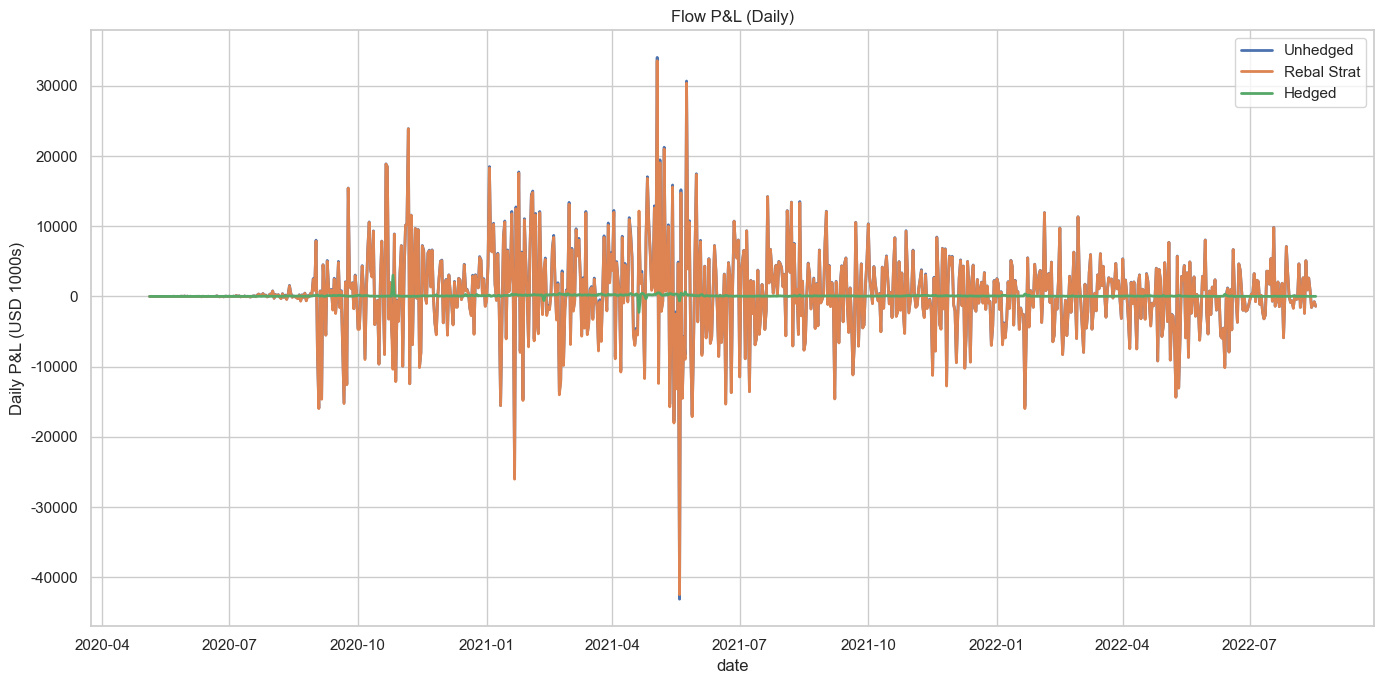

In [5]:
import seaborn as sns

plot_data = pd.concat([
    agg[["date", "pool_pnl"]].rename(columns={"pool_pnl": "y"}).assign(type="Unhedged"),
    agg[["date", "rebal_minute_pnl"]].rename(columns={"rebal_minute_pnl": "y"}).assign(type="Rebal Strat"),
    agg[["date", "hedged_pnl_minute"]].rename(columns={"hedged_pnl_minute": "y"}).assign(type="Hedged")
])

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.lineplot(data=plot_data, x="date", y="y", hue="type", linewidth=2)
plt.ylabel("Daily P&L (USD 1000s)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
plt.title("Flow P&L (Daily)")
plt.tight_layout()
plt.legend(title="")
plt.show()


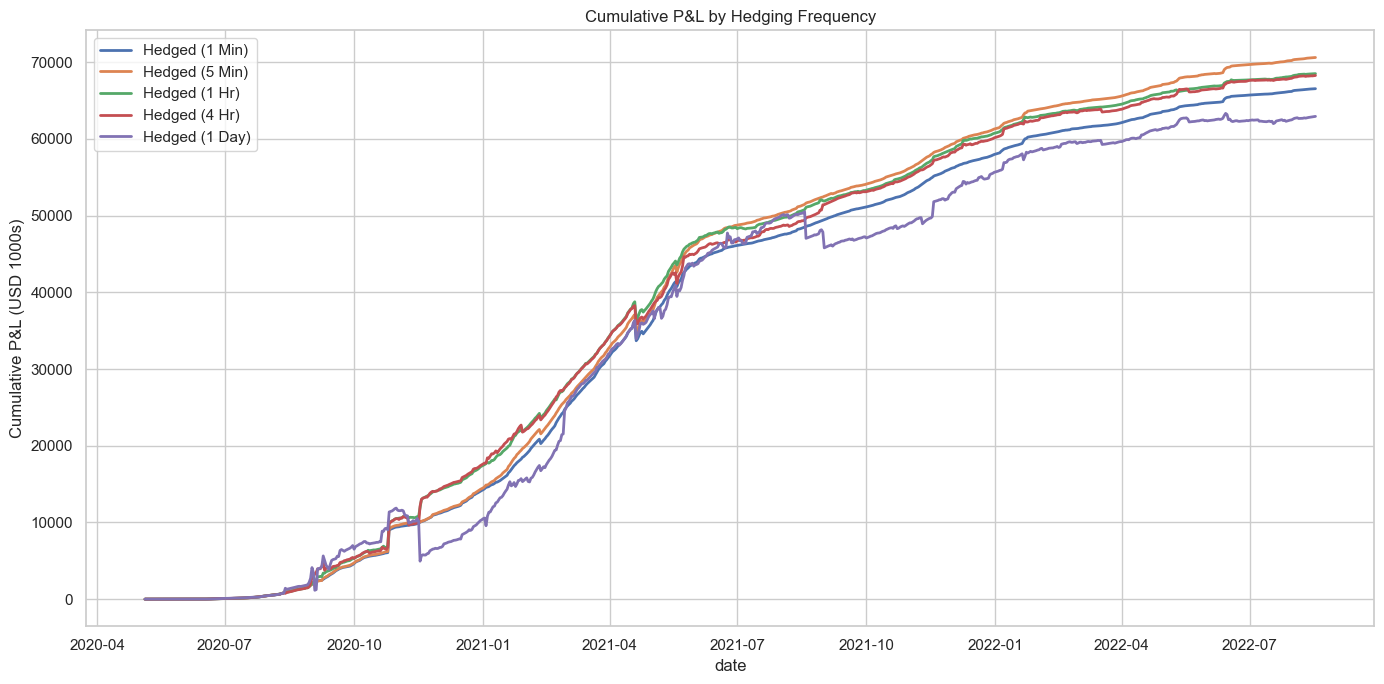

In [6]:
plot_data = pd.concat([
    # agg[["date", "cum_pool_pnl"]].rename(columns={"cum_pool_pnl": "y"}).assign(type="Unhedged"),
    agg[["date", "cum_hedged_pnl_minute"]].rename(columns={"cum_hedged_pnl_minute": "y"}).assign(type="Hedged (1 Min)"),
    agg[["date", "cum_hedged_pnl_5min"]].rename(columns={"cum_hedged_pnl_5min": "y"}).assign(type="Hedged (5 Min)"),
    agg[["date", "cum_hedged_pnl_hour"]].rename(columns={"cum_hedged_pnl_hour": "y"}).assign(type="Hedged (1 Hr)"),
    agg[["date", "cum_hedged_pnl_4hour"]].rename(columns={"cum_hedged_pnl_4hour": "y"}).assign(type="Hedged (4 Hr)"),
    agg[["date", "cum_hedged_pnl_day"]].rename(columns={"cum_hedged_pnl_day": "y"}).assign(type="Hedged (1 Day)")
])

plt.figure(figsize=(14, 7))
sns.lineplot(data=plot_data, x="date", y="y", hue="type", linewidth=2)
plt.ylabel("Cumulative P&L (USD 1000s)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
plt.title("Cumulative P&L by Hedging Frequency")
plt.tight_layout()
plt.legend(title="")
plt.show()


In [7]:
# --- Load and concatenate swap data ---
ETH_DEC = 1e18  # For amount0*
USDC_DEC = 1e6  # For amount1* — assuming the dataset uses 18 decimals for USDC
swap_files = ["swap0.csv", "swap1.csv", "swap2.csv", "swap3.csv", "swap4.csv", "tradesv2.csv"]
swap_dfs = [pd.read_csv("uniswap_lp_data/data_replication_lvr/" + f, parse_dates=["minute"]) for f in swap_files]
swaps = pd.concat(swap_dfs, ignore_index=True).sort_values("minute")

# Floor to the minute to match Binance data
swaps["minute"] = swaps["minute"].dt.floor("min")

# Merge with price from binance (already in data["time"] and data["close_price"])
price_df = data[["time", "close_price"]].drop_duplicates().rename(columns={"time": "minute"})
swaps = swaps.merge(price_df, on="minute", how="left")
print(swaps.dtypes)

# Ensure numeric types for amount columns
for col in ["amount0In", "amount0Out", "amount1In", "amount1Out"]:
    swaps[col] = pd.to_numeric(swaps[col], errors="coerce")

# Also ensure price is float
swaps["close_price"] = pd.to_numeric(swaps["close_price"], errors="coerce")

print(swaps.dtypes)

swaps["amount0In"] = swaps["amount0In"] / USDC_DEC
swaps["amount0Out"] = swaps["amount0Out"] / USDC_DEC
swaps["amount1In"] = swaps["amount1In"] / ETH_DEC
swaps["amount1Out"] = swaps["amount1Out"] / ETH_DEC
# Fill missing prices if any (linear interpolation if needed)
#swaps["close_price"] = swaps["close_price"].interpolate()

# --- Fees ---
fee_rate = 0.003
swaps["fee_ETH"] = fee_rate * swaps["amount1In"]
swaps["fee_USDC"] = fee_rate * swaps["amount0In"]
# swaps["fee_ETH"] = fee_rate * (swaps["amount1In"] + swaps["amount1Out"])
# swaps["fee_USDC"] = fee_rate * (swaps["amount0In"] + swaps["amount0Out"])
swaps["fees"] = swaps["fee_USDC"] + swaps["fee_ETH"] * swaps["close_price"]

# Aggregate fees by minute
fee_by_minute = swaps.groupby("minute", as_index=False)["fees"].sum()

# Merge fees into main dataset
data = data.copy()
data = pd.merge(data, fee_by_minute, how="left", left_on="time", right_on="minute")
data["fees"] = data["fees"].fillna(0)

dt = 1 / (24 * 60)  # One-minute step
# --- Realized volatility estimation (σ² per day from log returns) ---
data["log_ret"] = np.log(data["close_price"]).diff()
data["day"] = data["time"].dt.floor("D")
daily_var = data.groupby("day")["log_ret"].var().rename("sigma2")
daily_var = daily_var / dt
data = data.merge(daily_var, left_on="day", right_index=True)

# --- LVR ---
data["LVR"] = (data["sigma2"] / 8) * data["pool_value"] * dt

# --- Fees - LVR ---
data["fees_minus_LVR"] = data["fees"] - data["LVR"]

# --- Daily aggregation ---
fees_lvr_agg = data.groupby("date")["fees_minus_LVR"].sum().reset_index()
fees_lvr_agg["fees_minus_LVR"] = fees_lvr_agg["fees_minus_LVR"]/1e3

amount0In                    int64
amount0Out                   int64
amount1In                   object
amount1Out                  object
minute         datetime64[ns, UTC]
close_price                float64
dtype: object
amount0In                    int64
amount0Out                   int64
amount1In                  float64
amount1Out                 float64
minute         datetime64[ns, UTC]
close_price                float64
dtype: object


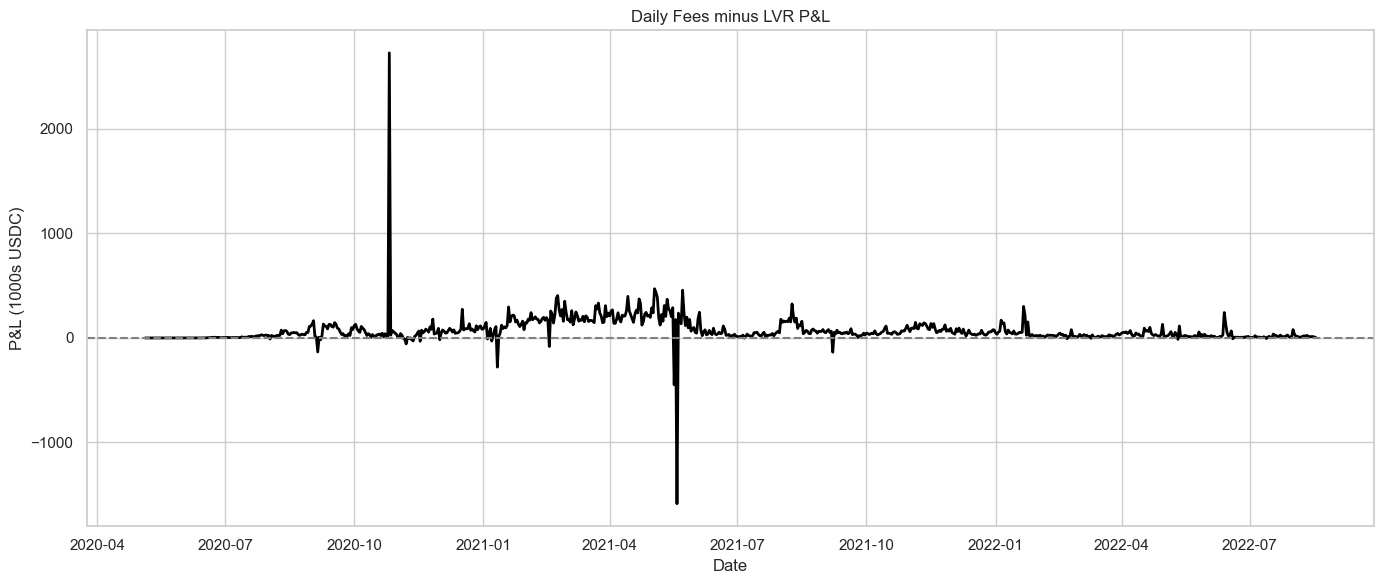

In [8]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=fees_lvr_agg, x="date", y="fees_minus_LVR", color="black", linewidth=2)
plt.title("Daily Fees minus LVR P&L")
plt.xlabel("Date")
plt.ylabel("P&L (1000s USDC)")
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()

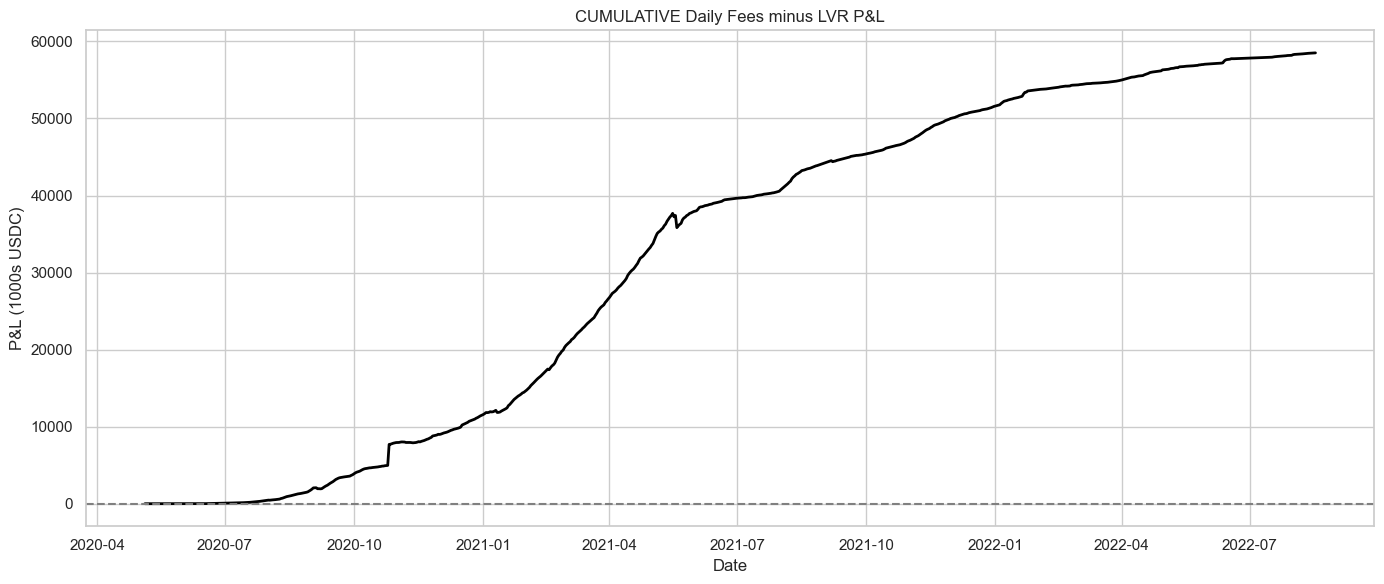

In [9]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=fees_lvr_agg.set_index("date").cumsum(), x="date", y="fees_minus_LVR", color="black", linewidth=2)
plt.title("CUMULATIVE Daily Fees minus LVR P&L")
plt.xlabel("Date")
plt.ylabel("P&L (1000s USDC)")
plt.axhline(0, color="gray", linestyle="--")
plt.tight_layout()
plt.show()


In [10]:
agg = agg.set_index("date")

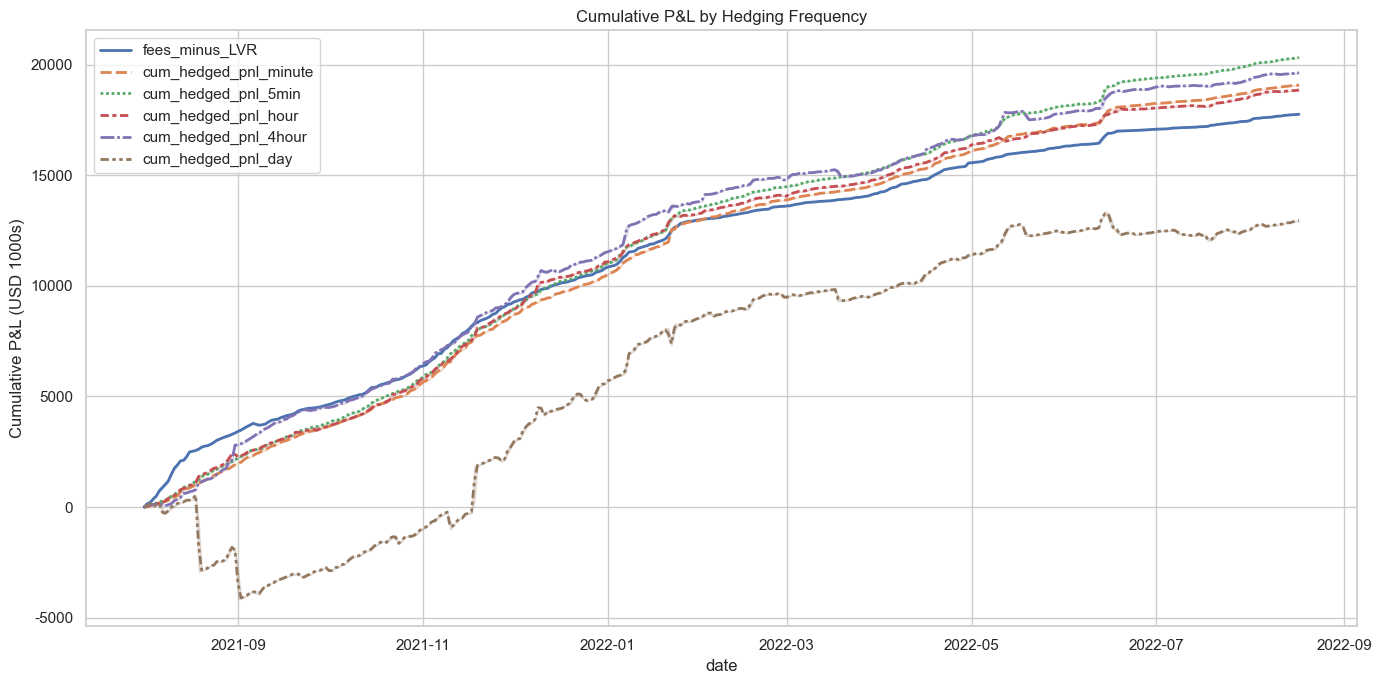

In [11]:
fees_minus_lvr_pnl = 1e3 * fees_lvr_agg.set_index("date")["fees_minus_LVR"]

fees_minus_lvr_pnl = fees_minus_lvr_pnl.cumsum()


plot_data = pd.concat([
    # agg[["date", "cum_pool_pnl"]].rename(columns={"cum_pool_pnl": "y"}).assign(type="Unhedged"),
    fees_minus_lvr_pnl,
    agg[["cum_hedged_pnl_minute"]],#.assign(type="Hedged (1 Min)"),
    agg[["cum_hedged_pnl_5min"]],#.assign(type="Hedged (5 Min)"),
    agg[["cum_hedged_pnl_hour"]],#.assign(type="Hedged (1 Hr)"),
    agg[["cum_hedged_pnl_4hour"]],#.assign(type="Hedged (4 Hr)"),
    agg[["cum_hedged_pnl_day"]],#.assign(type="Hedged (1 Day)")
])


plot_data = plot_data[plot_data.index >= pd.to_datetime("2021-08-01").date()]
plot_data = plot_data.sort_index()

plot_data = plot_data.ffill().bfill()

plot_data = plot_data - plot_data.iloc[0]

plt.figure(figsize=(14, 7))
sns.lineplot(data=plot_data, linewidth=2)
plt.ylabel("Cumulative P&L (USD 1000s)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1000:.0f}"))
plt.title("Cumulative P&L by Hedging Frequency")
plt.tight_layout()
plt.legend(title="")
plt.show()
